# Neural Networks, Dimensionality Reduction and Mixture Models on MNIST dataset

We import all the necessary packages into the notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 
from scipy.spatial.distance import pdist
from matplotlib.patches import Rectangle
from scipy.sparse import linalg

## Multi-Layer Perceptron (MLP)

We first load the training set *MNIST_train.csv* and test set *MNIST_test.csv* into pandas data frames, then convert them into numpy arrays.

In [2]:
MNIST_train = pd.read_csv("MNIST_train.csv")
MNIST_test = pd.read_csv("MNIST_test.csv")

In [3]:
MNIST_train = MNIST_train.to_numpy()
MNIST_test = MNIST_test.to_numpy()

We now split the training set into predictor set `x_train` and target `y_train`. We also split the test set into predictor set `x_test` and target `y_test`.

In [4]:
x_train = MNIST_train[:, 1:]
y_train = MNIST_train[:, 0]
x_test = MNIST_test[:, 1:]
y_test = MNIST_test[:, 0]

We visualise the first image of the training set with its label.

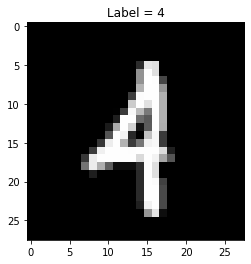

In [5]:
plt.figure(figsize=(4,4))
plt.imshow(x_train[0,:].reshape(28,28), cmap='gray')
plt.title("Label = {}".format(y_train[0]))
plt.show()

The `dense` function implements the dense layer transformation to obtain the pre-activation values.

In [6]:
def dense(x, W, b):
    """
    Arguments:
        x: K x h_in array of inputs
        W: h_in x h_out array for kernel matrix parameters
        b: Length h_out 1-D array for bias parameters
    
    Returns: 
        h: K x h_out output array 
    """
    
    h = b + x @ W
    return h

The hidden layers of our model will use the `softplus` activation function:
$$\text{Softplus}(x) = \frac{\log(1+\exp(\beta x))}{\beta} = \log(1 + \exp(x)) \quad \text{with} \quad \beta=1$$
To prevent overflow when $x\geq0$, we modify the `softplus` activation function:
$$\text{Softplus}(x) = \log(\exp(x)(1 + \exp(-x)) = x + \log(1 + \exp(-x))$$
Thus, the modified `softplus` activation function is:
$$\text{Softplus}(x) = \max(0, x) + \log(1 + \exp(-|x|))$$

In [7]:
def softplus(h):
    """
    Arguments:
        h: K x h_out array of pre-activations
    Returns:
        K x h_out output array 
    """
    h = np.maximum(0, h) + np.log(1 + np.exp(-np.abs(h)))
    return h

The output layer of our model will use the `softmax` activation function:
$$\text{softmax}(x)_{j}=\frac{\exp(x_{j})}{\sum_{i}{\exp(x_{i})}}$$
Again, to prevent overflow when $x\geq0$, we modify the `softmax` activation function:
$$\text{softmax}(x)_{j} = \frac{\exp(x_{j} - a)}{\sum_{i}{\exp(x_{i} - a)}}$$
where $a = \max(x)$.

In [8]:
def softmax(h):
    """
    Arguments:
        h: K x h_out array of pre-activations
    Returns:
        y: K x h_out of predictions
    """
    a = np.max(h, axis=1, keepdims=True)
    exp = np.exp(h-a)
    y = exp / np.sum(exp, axis=1, keepdims=True)
    return y

Our MLP will need the following parameters:

Input layer -> first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{784\times 200}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{200}$

Hidden layer -> hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{200\times 200}$, $k=1, 2$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{200}$, $k=1, 2$

Hidden layer -> output layer:
* Kernel $\boldsymbol{W}^{(3)} \in\mathbb{R}^{200\times 10}$
* Bias $\boldsymbol{b}^{(3)} \in\mathbb{R}^{10}$

We will create these parameters as numpy arrays, and initialise the kernel values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. The bias parameters will be initialised to zeros. <br>
The `initialise` function will create these parameters.

In [9]:
def initialise(x, n):
    """
    Arguments:
        x: K x h_in array of inputs
        n: number of neurons in hidden layer
    Returns:
        W0: h_in x n weights at 1st hidden layer
        b0: n x 1 biases at 1st hidden layer
        W1: n x n weights at 2nd hidden layer
        b1: n x 1 biases at 2nd hidden layer
        W2: n x n weights at 3rd hidden layer
        b2: n x 1 biases at 3rd hidden layer
        W3: n x 10 weights at output layer
        b3: 10 x 1 biases at output layer
    """
    p, q = x.shape
    
    var0 = 2. / (n + q)
    W0 = np.random.randn(q, n) * np.sqrt(var0)
    b0 = np.zeros(n)

    var1 = 2. / (n + n)
    W1 = np.random.randn(n, n) * np.sqrt(var1)
    b1 = np.zeros(n)

    var2 = 2. / (n + n)
    W2 = np.random.randn(n, n) * np.sqrt(var2)
    b2 = np.zeros(n)

    var3 = 2. / (10 + n)
    W3 = np.random.randn(n, 10) * np.sqrt(var3)
    b3 = np.zeros(10)
    
    return W0, b0, W1, b1, W2, b2, W3, b3

The `mlp` function implements the multilayer perceptron.
\begin{align*}
\boldsymbol{h}^{(0)} &= \boldsymbol{x} \\
\boldsymbol{h}^{(k)} &= \text{Softplus}(\boldsymbol{W}^{(k-1)}\boldsymbol{h}^{(k-1)} + \boldsymbol{b}^{(k-1)}), \quad k = 1,2,3 \\
\boldsymbol{\hat{y}} &= \text{softmax}(\boldsymbol{W}^{(3)}\boldsymbol{h}^{(3)} + \boldsymbol{b}^{(3)})
\end{align*}

In [10]:
def mlp(x, W0, b0, W1, b1, W2, b2, W3, b3):
    """
    Arguments:
        x: K x h_in array of inputs
        W0: h_in x n weights at 1st hidden layer
        b0: n x 1 biases at 1st hidden layer
        W1: n x n weights at 2nd hidden layer
        b1: n x 1 biases at 2nd hidden layer
        W2: n x n weights at 3rd hidden layer
        b2: n x 1 biases at 3rd hidden layer
        W3: n x 10 weights at output layer
        b3: 10 x 1 biases at output layer
    Returns:
        y: K x 10 array of outputs 
    """
    
    h = dense(x, W0, b0)
    h = softplus(h)
    h = dense(h, W1, b1)
    h = softplus(h)
    h = dense(h, W2, b2)
    h = softplus(h)
    h = dense(h, W3, b3)
    y = softmax(h)
    return y

The loss function used is KL divergence which is computed via:
$$L_{i}(y, \hat{y})=\sum_{i=1}^{N}{y_{i}\log\bigg(\frac{y_{i}}{\hat{y}_{i}}
\bigg)}$$
where $y_{i}$ is the true output and $\hat{y}_{i}$ is the predicted output. <br>
Under the assumption that k is the true label, $y_{i}$ equals 1 for $i=k$ and equals 0 for $i\neq k$.
Thus, we can further simplify the KL divergence loss function:
$$L_{i}(y, \hat{y})=y_{k}\log\bigg(\frac{y_{k}}{\hat{y}_{k}}\bigg) = \log\bigg(\frac{1}{\hat{y}_{k}}\bigg)=-\log(\hat{y}_{k})$$
The `kl_divergence` function defined computes the the average KL divergence of a sample of data points.

In [11]:
def kl_divergence(y_test, y_pred):
    """
    Arguments:
        y_test: K x 10 array of true outputs
        y_pred: K x 10 array of predicted outputs
    Returns:
        average KL divergence
    """
    y_test = np.eye(10)[y_test]
    return np.mean(-np.log(np.sum(y_pred * y_test, axis=1)))

The derivative of KL divergence with respect to the predicted output is:
$$\frac{\partial L_{i}}{\partial \hat{y}_{i}} 
= \begin{cases}
-\frac{1}{\hat{y}_{i}} \quad \text{if} \quad i=k\\
0 \quad \text{otherwise}
\end{cases}
$$
The derivative of softmax with respect to the pre-activations at the output layer is:
$$
\frac{\partial \hat{y}_{i}}{\partial a_{p}^{(4)}}
= \begin{cases}
\hat{y}_{i}(1-\hat{y}_{i}) \quad \text{if} \quad i=p\\
-\hat{y}_{i}\hat{y}_{p} \quad \text{otherwise}
\end{cases}
$$
Thus, we can derive the `output_error` as:
\begin{align*}
\frac{\partial L}{\partial a_{p}^{(4)}}
&= \sum_{i=1}^{N}\frac{\partial L}{\partial \hat{y}_{i}} \cdot \frac{\partial \hat{y}_{i}}{\partial a_{p}^{(4)}}\\
&= -\frac{1}{\hat{y}_{k}} \cdot \frac{\partial \hat{y}_{k}}{\partial a_{p}^{(4)}} \quad \text{if} \quad i=k\\
& = -\frac{1}{\hat{y}_{k}} \cdot 
\begin{cases}
\hat{y}_{k}(1-\hat{y}_{k}) \quad \text{if} \quad p=k\\
-\hat{y}_{k}\hat{y}_{p} \quad \text{otherwise}
\end{cases} \\
&= \begin{cases}
\hat{y}_{k} - 1 \quad \text{if} \quad p=k\\
\hat{y}_{p} \quad \text{otherwise}
\end{cases} \\
&= \hat{y} - c
\end{align*}
where c is the one hot encoding for the true label k.

In [12]:
def output_error(y_batch, y_pred):
    """
    Arguments:
        y_batch: K x 10 array of true outputs
        y_pred: K x 10 array of predicted outputs
    Returns:
        K x 10 array of output errors
    """
    y_test = np.eye(10)[y_batch]
    return y_pred - y_test

The `softplus_derivative` function computes the derivative of the softplus activation function as:
$$\frac{\partial}{\partial x}(\log(1+\exp(x))=\frac{\exp(x)}{1+\exp(x)}=\frac{1}{1+\exp(-x)}$$
To prevent overflow, we modify the `softplus_derivative` function:
$$\frac{\partial}{\partial x}(\log(1+\exp(x))=\exp(-\log(\exp(0)+\exp(-x)))$$

In [13]:
def softplus_derivative(a1):
    """
    Arguments:
        a1: K x h_out array of hidden layer pre-activations
    Returns:
        derivative of softplus activation function
    """        
    return np.exp(-np.logaddexp(0, -a1))

The `backpropagate` function backpropagates the errors to compute $\mathbf{\delta}^{(k)}$ for each hidden unit using $\boldsymbol{\delta}^{(k)} = \boldsymbol{\sigma}'(\boldsymbol{a}^{(k)})  \boldsymbol{W}^{(k)} \boldsymbol{\delta}^{(k+1)}$.

In [14]:
def backpropagate(delta2, W1, a1):
    """
    Arguments:
        delta2: array of output errors
        W1: array of weights
        a1: array of hidden layer pre-activations
    Returns:
        array of hidden layer errors
    """
    return np.sum(softplus_derivative(a1)[..., np.newaxis] * W1 * delta2[:, np.newaxis, :], axis=-1) # edit

Given the errors $\boldsymbol{\delta}^{(1)}$, $\boldsymbol{\delta}^{(2)}$ $\boldsymbol{\delta}^{(3)}$ and $\boldsymbol{\delta}^{(4)}$ and post-activations $\boldsymbol{h}^{(0)}$ ($=\boldsymbol{x}$), $\boldsymbol{h}^{(1)}$, $\boldsymbol{h}^{(2)}$ and $\boldsymbol{h}^{(3)}$, we can compute the gradients $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W}^{(0)}}$, $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b}^{(0)}}$, $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W}^{(1)}}$, $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b}^{(1)}}$, $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W}^{(2)}}$, $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b}^{(2)}}$, $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{W}^{(3)}}$ and $\frac{\partial\mathcal{L}_i}{\partial \boldsymbol{b}^{(3)}}$.

The `grad` function obtains the derivatives of $\mathcal{L}_i$ with respect to the weights and biases using $\frac{\partial \mathcal{L}_i}{\partial w^{(k)}_{pq}} = \delta^{(k+1)}_p h^{(k)}_q,\quad 
\frac{\partial \mathcal{L}_i}{\partial b^{(k)}_{p}} = \delta^{(k+1)}_p$, averaged over the batch size.

In [15]:
def grads(delta1, delta2, delta3, delta4, h0, h1, h2, h3):
    """
    Arguments:
        delta1: K x 200 array of hidden layer errors
        delta2: K x 200 array of hidden layer errors
        delta3: K x 200 array of hidden layer errors
        delta4: K x 10 array of output errors
        h0: K x 784 array of inputs
        h1: K x 200 array of hidden layer post-activations
        h2: K x 200 array of hidden layer post-activations
        h3: K x 200 array of hidden layer post-activations
    Returns:
        grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3
    """
    grad_W0 = delta1[:, np.newaxis, :] * h0[:, :, np.newaxis]
    grad_b0 = delta1
    grad_W1 = delta2[:, np.newaxis, :] * h1[:, :, np.newaxis]
    grad_b1 = delta2
    grad_W2 = delta3[:, np.newaxis, :] * h2[:, :, np.newaxis]
    grad_b2 = delta3
    grad_W3 = delta4[:, np.newaxis, :] * h3[:, :, np.newaxis]
    grad_b3 = delta4
    
    grad_W0 = np.mean(grad_W0, axis=0)
    grad_b0 = np.mean(grad_b0, axis=0)
    grad_W1 = np.mean(grad_W1, axis=0)
    grad_b1 = np.mean(grad_b1, axis=0)
    grad_W2 = np.mean(grad_W2, axis=0)
    grad_b2 = np.mean(grad_b2, axis=0)
    grad_W3 = np.mean(grad_W3, axis=0)
    grad_b3 = np.mean(grad_b3, axis=0)
    
    return grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3

The `train_neural` function implements stochastic gradient descent to optimise the neural network parameters.

In [16]:
def train_neural(x_train, y_train, batch_size, epochs, learning_rate, n):
    """
    Arguments:
        x_train: K x 784 array of inputs
        y_train: K x 1 array of true labels
        batch_size: size of each minibatch
        epochs: number of epochs
        learning_rate: learning rate of SGD
        n: number of neurons in hidden layer
    Returns:
        loss_list: list containing lists of losses for each epoch
    """
    p, q = x_train.shape
    num_batches = p // batch_size
    
    loss_list = []
    indices = np.arange(len(y_train))
    
    # initialise the neural network paramters
    W0, b0, W1, b1, W2, b2, W3, b3 = initialise(x_train, n)
    
    for epoch in range(epochs):
        
        # generate batches of training data
        np.random.shuffle(indices)
        batches = []
        for k in range(num_batches):
            batches.append(indices[k*batch_size:(k+1)*batch_size])
        batches.append(indices[num_batches*batch_size:])
        
        for i in range(len(batches)):
            x_batch, y_batch = x_train[batches[i], :], y_train[batches[i]]
            
            # forward pass
            a1 = dense(x_batch, W0, b0)
            h1 = softplus(a1)
            a2 = dense(h1, W1, b1)
            h2 = softplus(a2)
            a3 = dense(h2, W2, b2)
            h3 = softplus(a3)
            a4 = dense(h3, W3, b3)
            y_pred = softmax(a4)

            # backpropagate
            delta4 = output_error(y_batch, y_pred)
            delta3 = backpropagate(delta4, W3, a3)
            delta2 = backpropagate(delta3, W2, a2)
            delta1 = backpropagate(delta2, W1, a1)

            # compute gradient and update the neural network parameters
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = grads(delta1, delta2, delta3, delta4, x_batch, h1, h2, h3)
            W0 -= learning_rate * grad_W0
            b0 -= learning_rate * grad_b0
            W1 -= learning_rate * grad_W1
            b1 -= learning_rate * grad_b1
            W2 -= learning_rate * grad_W2
            b2 -= learning_rate * grad_b2
            W3 -= learning_rate * grad_W3
            b3 -= learning_rate * grad_b3
        
        # predict output and compute loss
        y_train_pred = mlp(x_train, W0, b0, W1, b1, W2, b2, W3, b3)
        loss = kl_divergence(y_train, y_train_pred)
        loss_list.append(loss)
        
    return loss_list

We train the MLP on batches of 128 data points for 40 epochs. We repeat this for 6 different learning rates between $10^{-5}$ and $10^{-1}$.

In [17]:
lr_list = 10**np.arange(-4.5, -2.25, 0.5, dtype=float)
lr_list = np.append(lr_list, 10**(-2.3))
losses_list = []
losses = []
for lr in lr_list:
    loss_list = train_neural(x_train, y_train, 128, 40, lr, 200)
    losses_list.append(loss_list)
    losses.append(loss_list[-1])

We now plot the loss against the number of epochs for each learning rate.

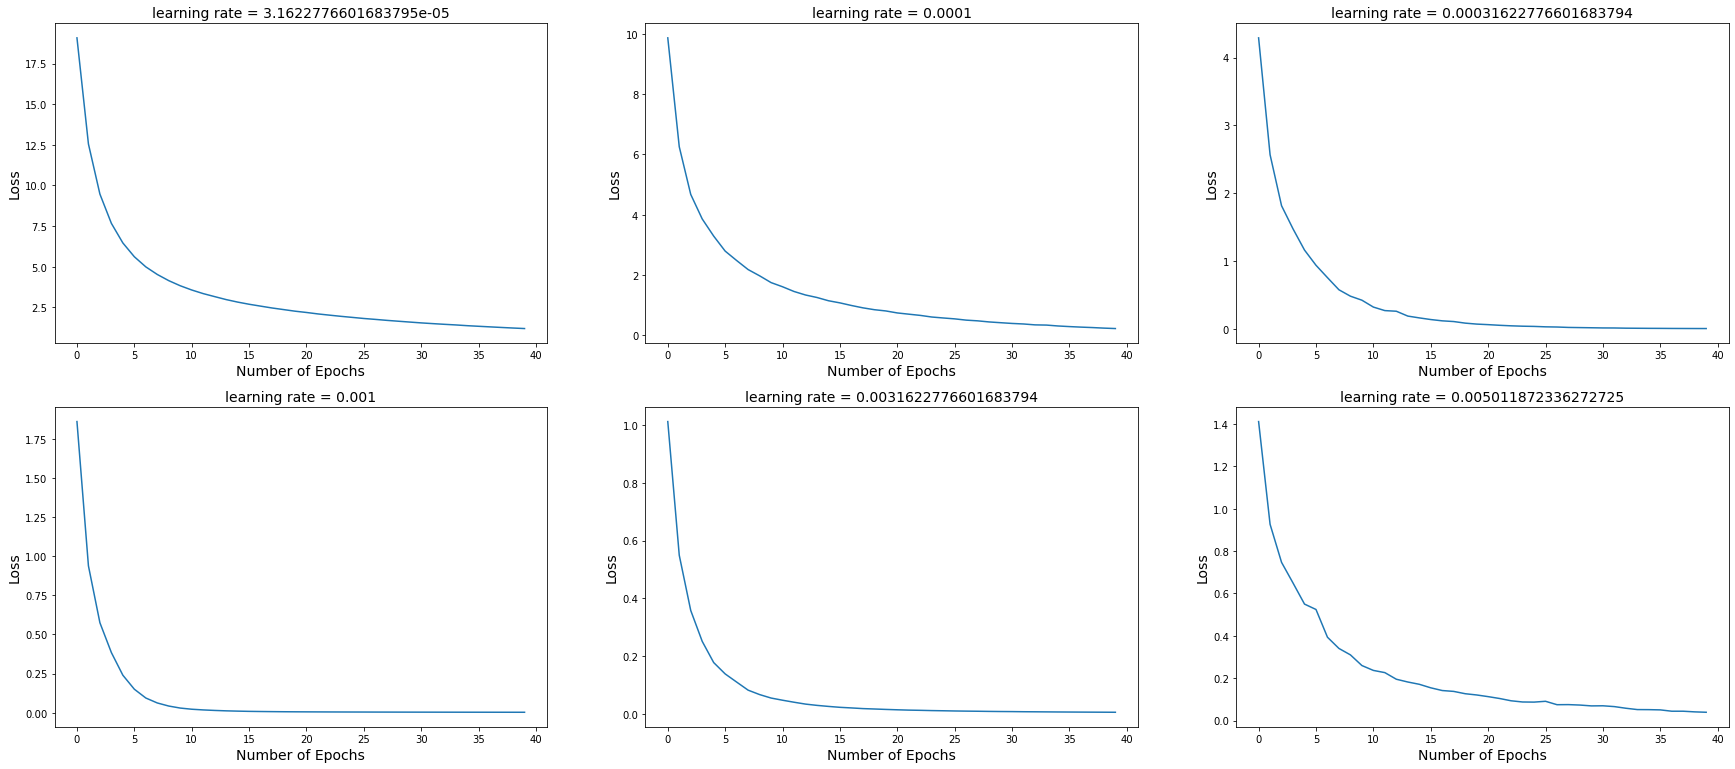

In [18]:
fig = plt.figure(figsize=(30, 20))

for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.plot(losses_list[i])
    plt.title("learning rate = {}".format(lr_list[i]), fontsize=14)
    plt.xlabel('Number of Epochs',fontsize=14)
    plt.ylabel('Loss',fontsize=14)

We can observe that for each learning rate the loss gradually converges towards 0 as the number of epochs increases. We notice that the number of epochs required for convergence decreases as learning rate increases to 0.001 and increases after that. <br>
We now plot the final loss achieved for each learning rate value to determine the optimal learning rate.

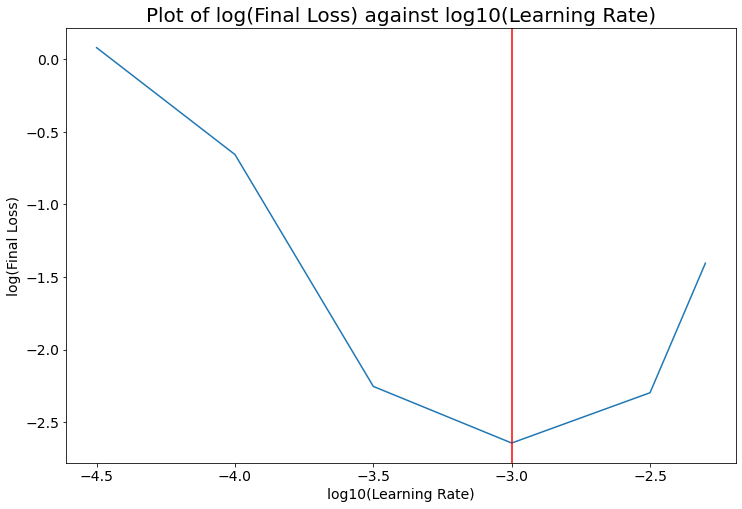

In [19]:
best_lr = lr_list[np.argmin(losses)]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(np.log10(lr_list), np.log10(losses))
plt.axvline(x=np.log10(best_lr), color="r")
plt.xlabel('log10(Learning Rate)',fontsize=14)
plt.ylabel('log(Final Loss)',fontsize=14)
plt.title("Plot of log(Final Loss) against log10(Learning Rate)", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

We can observe that the final loss achieved decreases when the learning rate increases to 0.001 and increases after that (U-shape), which implies that the learning rate of 0.001 gives the minimum final loss achieved. <br>
The trend conveys that a learning rate that is too small is unable to optimise the neural network parameters within 40 epochs. However, a learning rate that is too large is might overshoot the values of the optimal neural network parameters even though it converges faster, resulting in higher loss.

In [20]:
print("The optimal value of learning rate is {}".format(best_lr))

The optimal value of learning rate is 0.001


The `accuracy` function computes accuracy using the formula:
$$\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives and FN is the number of false negatives.

In [21]:
def accuracy(y_test, y_pred):
    """
    Arguments:
        y_test: K x 1 array of true labels
        y_pred: K x 10 array of predicted output
    Returns:
        accuracy score
    """
    y_pred = np.argmax(y_pred, axis=1)
    return np.mean(y_pred==y_test)

The `train_neural_2` function performs the same process as the `train_neural` function, but in addition to computing the training loss, it also computes the test loss, training accuracy and test accuracy. It also returns the neural network parameters in the first hidden layer.

In [22]:
def train_neural_2(x_train, y_train, batch_size, epochs, learning_rate, n, x_test, y_test):
    """
    Arguments:
        x_train: K x 784 array of inputs
        y_train: K x 1 array of true labels
        batch_size: size of each minibatch
        epochs: number of epochs
        learning_rate: learning rate of SGD
        n: number of neurons in hidden layer
        x_test: N x 784 array of test inputs
        y_test: N x 1 array of true test labels
    Returns:
        train_loss_list: list containing lists of training losses for each epoch
        test_loss_list: list containing lists of test losses for each epoch
        train_accuracy_list: list containing lists of training accuracy for each epoch
        test_accuracy_list: list containing lists of test accuracy for each epoch
        W0: h_in x n weights at 1st hidden layer
        b0: n x 1 biases at 1st hidden layer
    """
    p, q = x_train.shape
    num_batches = p // batch_size
    
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    indices = np.arange(len(y_train))
    
    # initialise the neural network parameters
    W0, b0, W1, b1, W2, b2, W3, b3 = initialise(x_train, n)
    
    for epoch in range(epochs):
        
        # generate batches of training data
        np.random.shuffle(indices)
        batches = []
        for k in range(num_batches):
            batches.append(indices[k*batch_size:(k+1)*batch_size])
        batches.append(indices[num_batches*batch_size:])
        
        for i in range(len(batches)):
            x_batch, y_batch = x_train[batches[i], :], y_train[batches[i]]
            
            # forward pass
            a1 = dense(x_batch, W0, b0)
            h1 = softplus(a1)
            a2 = dense(h1, W1, b1)
            h2 = softplus(a2)
            a3 = dense(h2, W2, b2)
            h3 = softplus(a3)
            a4 = dense(h3, W3, b3)
            y_pred = softmax(a4)

            # backpropagate
            delta4 = output_error(y_batch, y_pred)
            delta3 = backpropagate(delta4, W3, a3)
            delta2 = backpropagate(delta3, W2, a2)
            delta1 = backpropagate(delta2, W1, a1)

            # compute gradients and update neural network parameters
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = grads(delta1, delta2, delta3, delta4, x_batch, h1, h2, h3)
            W0 -= learning_rate * grad_W0
            b0 -= learning_rate * grad_b0
            W1 -= learning_rate * grad_W1
            b1 -= learning_rate * grad_b1
            W2 -= learning_rate * grad_W2
            b2 -= learning_rate * grad_b2
            W3 -= learning_rate * grad_W3
            b3 -= learning_rate * grad_b3
        
        # predict training and test outputs and compute training loss, test loss, training accuracy and test accuracy
        y_train_pred = mlp(x_train, W0, b0, W1, b1, W2, b2, W3, b3)
        y_test_pred = mlp(x_test, W0, b0, W1, b1, W2, b2, W3, b3)
        train_loss = kl_divergence(y_train, y_train_pred)
        train_loss_list.append(train_loss)
        test_loss = kl_divergence(y_test, y_test_pred)
        test_loss_list.append(test_loss)
        train_acc = accuracy(y_train, y_train_pred)
        train_accuracy_list.append(train_acc)
        test_acc = accuracy(y_test, y_test_pred)
        test_accuracy_list.append(test_acc)
        
    return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list, W0, b0

We retrain the MLP with the optimal learning rate of 0.001, using batches of 128 data points and 40 epochs again.

In [23]:
train_loss_list_200, test_loss_list_200, train_accuracy_list_200, test_accuracy_list_200, W0_200, b0_200 = train_neural_2(x_train, y_train, 128, 40, best_lr, 200, x_test, y_test)

We now plot the loss and accuracy of the MLP as a function of the number of epochs for both the training and test sets.

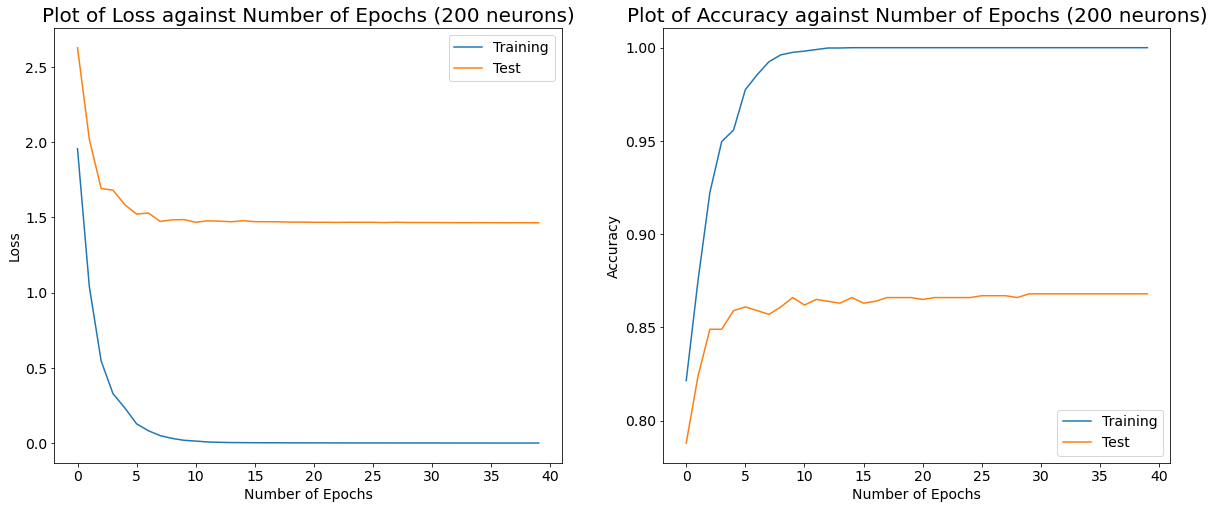

In [24]:
fig, ax = plt.subplots(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list_200, label="Training")
plt.plot(test_loss_list_200, label="Test")
plt.xlabel('Number of Epochs',fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("Plot of Loss against Number of Epochs (200 neurons)", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc="best",fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list_200, label="Training")
plt.plot(test_accuracy_list_200, label="Test")
plt.xlabel('Number of Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title("Plot of Accuracy against Number of Epochs (200 neurons)", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc="best",fontsize=14)
plt.show()

We retrain the MLP by reducing the width of the hidden layers to 50 neurons while keeping the batch size, number of epochs and learning rate constant.

In [55]:
train_loss_list_50, test_loss_list_50, train_accuracy_list_50, test_accuracy_list_50, W0_50, b0_50 = train_neural_2(x_train, y_train, 128, 40, best_lr, 50, x_test, y_test)

We now plot the the loss and accuracy of the MLP as a function of the number of epochs for both the training and test sets for the case where there are 50 neurons in each hidden layer.

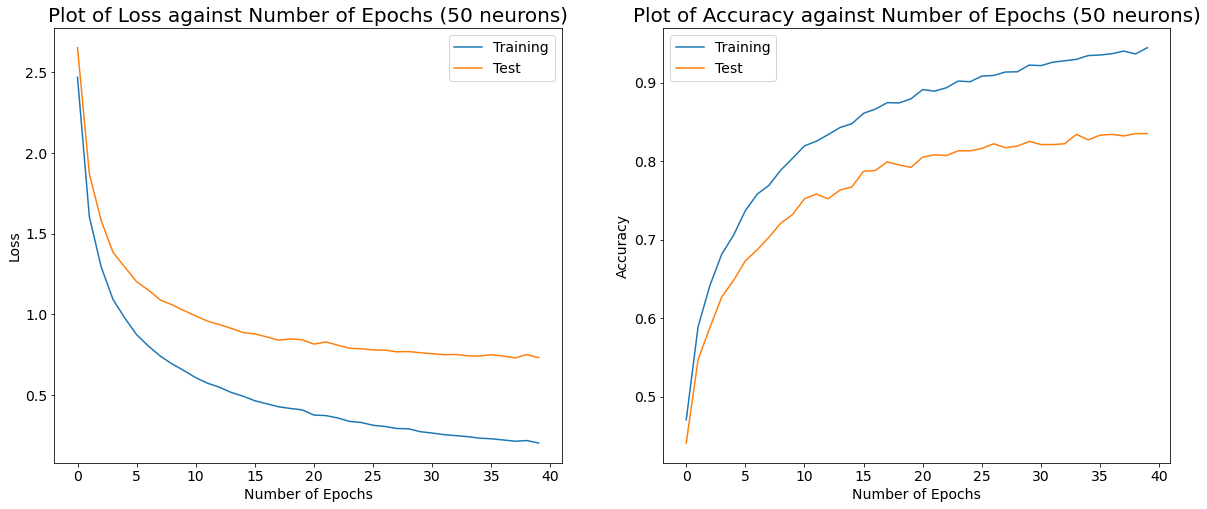

In [56]:
fig, ax = plt.subplots(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list_50, label="Training")
plt.plot(test_loss_list_50, label="Test")
plt.xlabel('Number of Epochs',fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("Plot of Loss against Number of Epochs (50 neurons)", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc="best",fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list_50, label="Training")
plt.plot(test_accuracy_list_50, label="Test")
plt.xlabel('Number of Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title("Plot of Accuracy against Number of Epochs (50 neurons)", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc="best",fontsize=14)
plt.show()

For the training set, we can observe that the convergence in loss for the MLP with 50 neurons in its hidden layers is slower than the MLP with 200 neurons in its hidden layers. We note that both losses gradually converges to 0. <br>

However, for the test set, we can see that the loss converges to 0.75 for the MLP with 50 neurons in its hidden layers while the loss converges to 1.5 for the MLP with 200 neurons in its hidden layers. This implies that reducing the number of neurons in the hidden layers of the MLP from 200 to 50 reduces overfitting. <br>

To better compare the accuracies, we plot the accuracy on both the training and test sets for both the MLP with 50 neurons in its hidden layers and the MLP with 200 neurons in its hidden layers together in one plot.

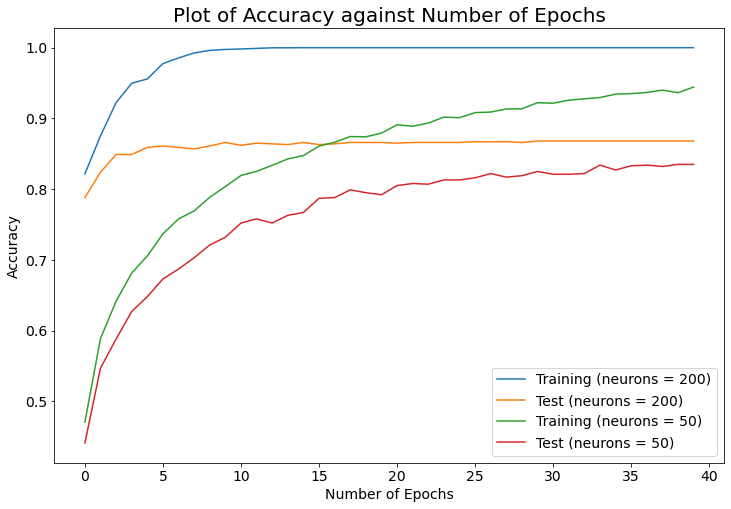

In [57]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(train_accuracy_list_200, label="Training (neurons = 200)")
plt.plot(test_accuracy_list_200, label="Test (neurons = 200)")
plt.plot(train_accuracy_list_50, label="Training (neurons = 50)")
plt.plot(test_accuracy_list_50, label="Test (neurons = 50)")
plt.xlabel('Number of Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title("Plot of Accuracy against Number of Epochs", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc="best",fontsize=14)
plt.show()

For the training set, we can observe that accuracy of the MLP with 50 neurons in its hidden layers is lower than the accuracy of the MLP with 200 neurons in its hidden layers. This implies that the MLP with 200 neurons in its hidden layers learns the patterns and relationships in the training data more effectively, and is able to make more accurate predictions on the training data. <br>

Similarly, for the test set, we can observe that accuracy of the MLP with 50 neurons in its hidden layers is lower than the accuracy of the MLP with 200 neurons in its hidden layers. This implies that the MLP with 200 neurons in its hidden layers is able to make more accurate predictions on the test data. <br>

However, we note that in terms of the difference between the accuracy on the training data and the accuracy on the test data, the MLP with 50 neurons in its hidden layers is smaller than the MLP with 200 neurons in its hidden layers, which implies less overfitting. In addition, the test accuracy of the MLP with 50 neurons in its hidden layers is just slightly lower than the test accuracy of the MLP with 200 neurons in its hidden layers, but in exchange it is less computationally expensive as it has less parameters to learn.

The `forward_dropout` function randomly replaces the activation values with zeros with a given dropout rate and scales the output of each neuron in the hidden layers to compensate for the dropout.

In [58]:
def forward_dropout(h, dropout_rate):
    """
    Arguments:
        h: K x h_in array of post-activations
        dropout_rate: probability of dropout
    Returns:
        h: K x h_in array of post-activations after dropout
        d: K x h_in array of Bernoulli mask with probability dropout_rate
    """
    d = np.random.rand(h.shape[0], h.shape[1])  # initialise matrix
    d = d < (1 - dropout_rate)  # convert entries of d1 to 0 or 1 using dropout rate
    h = np.multiply(h, d)  # shut down some neurons of h1
    h = h / (1 - dropout_rate)  # scale the value of neurons that have not been shut down
    return h, d

The `backward_dropout` function replaces the same neurons that have been dropout in the forward pass with zeros using the same Bernoulli mask and scales the errors with the same rate.

In [59]:
def backward_dropout(delta, d, dropout_rate):
    """
    Arguments:
        delta: K x 200 array of hidden layer errors
        d: K x h_in array of Bernoulli mask with probability dropout_rate
        dropout_rate: probability of dropout
    Returns:
        delta: K x 200 array of hidden layer errors after dropout
    """
    delta = np.multiply(d, delta)  # shut down the same neurons as during the forward dropout
    delta = delta / (1 - dropout_rate)  # scale the value of neurons that have not been shut down
    return delta

The `train_neural_dropout` function implements the same process as `train_neural_2`, but in addition implements dropout at each hidden layer.

In [60]:
def train_neural_dropout(x_train, y_train, batch_size, epochs, learning_rate, n, x_test, y_test, dropout_rate):
    """
    Arguments:
        x_train: K x 784 array of inputs
        y_train: K x 1 array of true labels
        batch_size: size of each minibatch
        epochs: number of epochs
        learning_rate: learning rate of SGD
        n: number of neurons in hidden layer
        x_test: N x 784 array of test inputs
        y_test: N x 1 array of true test labels
    Returns:
        train_loss_list: list containing lists of training losses for each epoch
        test_loss_list: list containing lists of test losses for each epoch
        train_accuracy_list: list containing lists of training accuracy for each epoch
        test_accuracy_list: list containing lists of test accuracy for each epoch
        W0: h_in x n weights at 1st hidden layer
        b0: n x 1 biases at 1st hidden layer
    """
    p, q = x_train.shape
    num_batches = p // batch_size
    
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    indices = np.arange(len(y_train))
    
    # initialise the neural network parameters
    W0, b0, W1, b1, W2, b2, W3, b3 = initialise(x_train, n)
    
    for epoch in range(epochs):
        
        # generate batches of training data
        np.random.shuffle(indices)
        batches = []
        for k in range(num_batches):
            batches.append(indices[k*batch_size:(k+1)*batch_size])
        batches.append(indices[num_batches*batch_size:])
        
        for i in range(len(batches)):
            x_batch, y_batch = x_train[batches[i], :], y_train[batches[i]]
            
            # forward pass
            a1 = dense(x_batch, W0, b0)
            h1 = softplus(a1)
            # dropout
            h1, d1 = forward_dropout(h1, dropout_rate)
            
            a2 = dense(h1, W1, b1)
            h2 = softplus(a2)
            # dropout
            h2, d2 = forward_dropout(h2, dropout_rate)
            
            a3 = dense(h2, W2, b2)
            h3 = softplus(a3)
            # dropout
            h3, d3 = forward_dropout(h3, dropout_rate)
            
            a4 = dense(h3, W3, b3)
            y_pred = softmax(a4)

            # backpropagate
            delta4 = output_error(y_batch, y_pred)
            
            delta3 = backpropagate(delta4, W3, a3)
            delta3 = backward_dropout(delta3, d3, dropout_rate)
            
            delta2 = backpropagate(delta3, W2, a2)
            delta2 = backward_dropout(delta2, d2, dropout_rate)
            
            delta1 = backpropagate(delta2, W1, a1)
            delta1 = backward_dropout(delta1, d1, dropout_rate)

            # compute gradients and update neural network parameters
            grad_W0, grad_b0, grad_W1, grad_b1, grad_W2, grad_b2, grad_W3, grad_b3 = grads(delta1, delta2, delta3, delta4, x_batch, h1, h2, h3)
            W0 -= learning_rate * grad_W0
            b0 -= learning_rate * grad_b0
            W1 -= learning_rate * grad_W1
            b1 -= learning_rate * grad_b1
            W2 -= learning_rate * grad_W2
            b2 -= learning_rate * grad_b2
            W3 -= learning_rate * grad_W3
            b3 -= learning_rate * grad_b3
        
        # predict training and test outputs and compute training loss, test loss, training accuracy and test accuracy
        y_train_pred = mlp(x_train, W0, b0, W1, b1, W2, b2, W3, b3)
        y_test_pred = mlp(x_test, W0, b0, W1, b1, W2, b2, W3, b3)
        train_loss = kl_divergence(y_train, y_train_pred)
        train_loss_list.append(train_loss)
        test_loss = kl_divergence(y_test, y_test_pred)
        test_loss_list.append(test_loss)
        train_acc = accuracy(y_train, y_train_pred)
        train_accuracy_list.append(train_acc)
        test_acc = accuracy(y_test, y_test_pred)
        test_accuracy_list.append(test_acc)
        
    return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list, W0, b0

We implement dropout with rate=0.2 at each hidden layer, using the same number of neurons at hidden layer of 200 as task **1.1.2**, but using a larger learning rate of 0.005 and a larger number of epochs of 60.

In [61]:
train_loss_list_dropout, test_loss_list_dropout, train_accuracy_list_dropout, test_accuracy_list_dropout, W0_dropout, b0_dropout = train_neural_dropout(x_train, y_train, 128, 60, 0.005, 200, x_test, y_test, 0.2)

We now plot the loss and accuracy of the MLP as a function of the number of epochs for both the training and test sets.

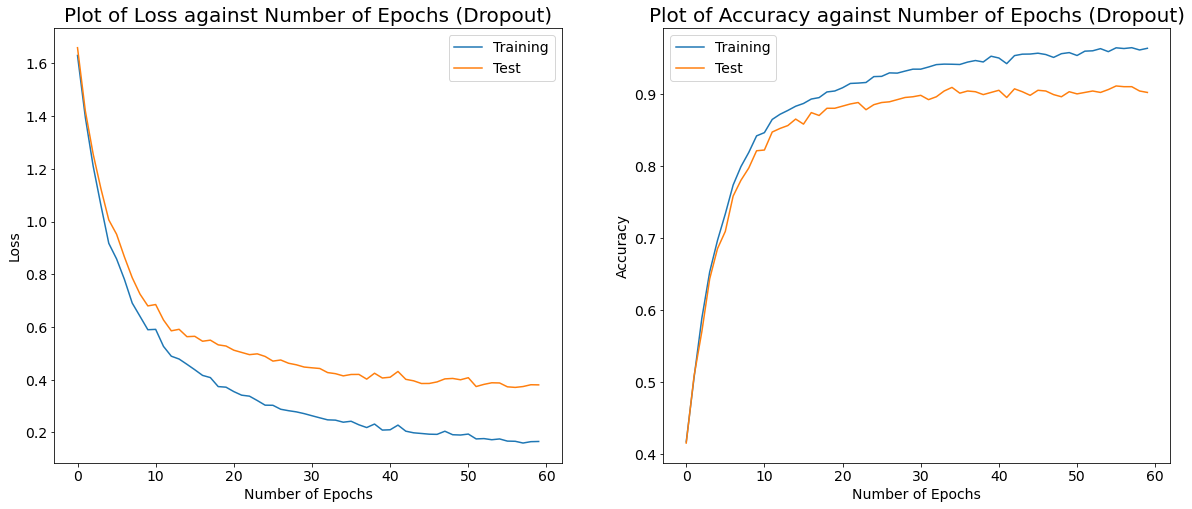

In [62]:
fig, ax = plt.subplots(figsize=(20,8))

plt.subplot(1, 2, 1)
plt.plot(train_loss_list_dropout, label="Training")
plt.plot(test_loss_list_dropout, label="Test")
plt.xlabel('Number of Epochs',fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title("Plot of Loss against Number of Epochs (Dropout)", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc="best",fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list_dropout, label="Training")
plt.plot(test_accuracy_list_dropout, label="Test")
plt.xlabel('Number of Epochs',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title("Plot of Accuracy against Number of Epochs (Dropout)", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc="best",fontsize=14)
plt.show()

In terms of training loss, the MLP with dropout converges to 0.2 while the MLP without dropout converges to 0. In terms of test loss, the MLP with dropout converges to 0.4 while the MLP without dropout converges to 1.5. This implies that implementing dropout reduces overfitting and is able to reduce loss. <br>

In terms of training accuracy, the MLP with dropout converges to 0.95 while the MLP without dropout converges to 1. In terms of test loss, the MLP with dropout converges to 0.9 while the MLP without dropout converges to 0.86. This further affirms our inference that implementing dropout reduces overfitting as well as suggests that this is able to increase accuracy. <br>

We now produce histograms of the activations of the units in the first hidden layer when the network is evaluated on a test set of bacth size 256 for both the network with dropout and without dropout.

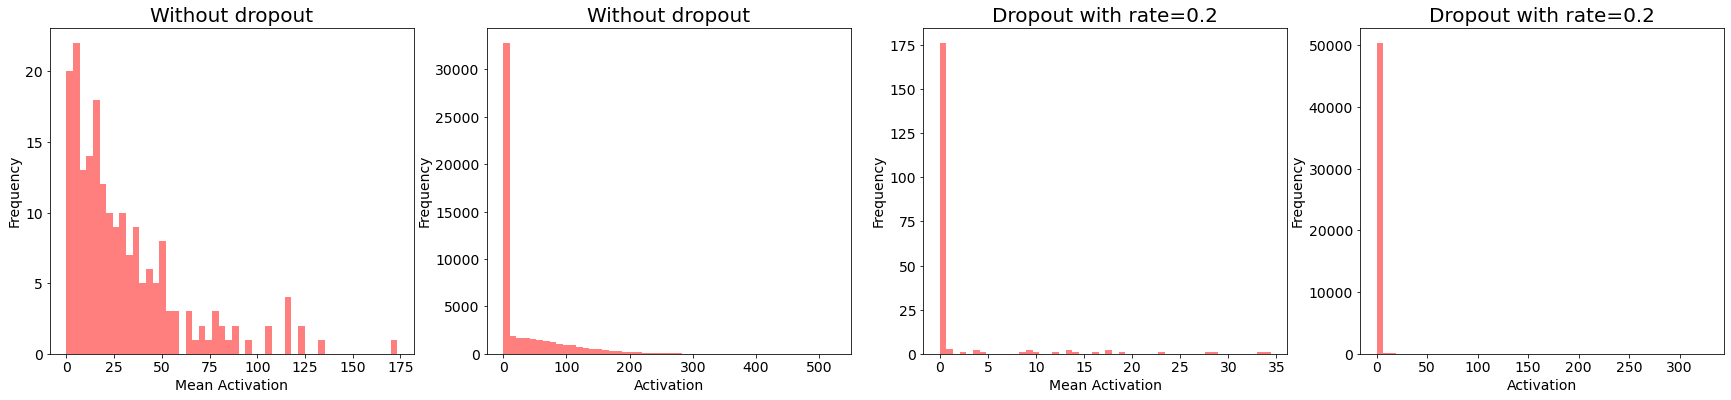

In [63]:
# test set with batch size of 256
test_batch = x_test[0:256,:]

# without dropout
h_200 = dense(test_batch, W0_200, b0_200)
h_200 = softplus(h_200)

# dropout with p = 0.2
h_dropout = dense(test_batch, W0_dropout, b0_dropout)
h_dropout = softplus(h_dropout)

# mean activations
h_200_mean = np.mean(h_200, axis=0)
h_dropout_mean = np.mean(h_dropout, axis=0)

fig, ax = plt.subplots(figsize=(30,6))

# histogram of activations
plt.subplot(1, 4, 1)
plt.hist(h_200_mean, bins=50, color='r', alpha=0.5)
plt.xlabel('Mean Activation',fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title("Without dropout", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(1, 4, 2)
plt.hist(h_200.flatten(), bins=50, color='r', alpha=0.5)
plt.xlabel('Activation',fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title("Without dropout", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(1, 4, 3)
plt.hist(h_dropout_mean, bins=50, color='r', alpha=0.5)
plt.xlabel('Mean Activation',fontsize=14)
plt.ylabel('Frequency',fontsize=14)
plt.title("Dropout with rate=0.2", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot(1, 4, 4)
plt.hist(h_dropout.flatten(), bins=50, color='r', alpha=0.5)
plt.xlabel('Activation',fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title("Dropout with rate=0.2", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

From the histograms of the activations of the units in the first hidden layer, we can infer that dropout induces sparsity. Comparing the histograms for mean activations, for the MLP without dropout, we observe that the mean activations are spread out across range of values with mode slightly away from zero while for the MLP with dropout, the mean activations of a large proportion of units concentrate at zero. Comparing the histograms for activations, for the MLP without dropout, there is a sharp peak at zero with frequency approximately 33000, followed by units of very high activations. However, for the MLP with dropout, the frequency of the sharp peak increases to 50000, showing that a larger proportion of the units have activations values of zero. <br>

Dropout randomly sets some of the weights in the MLP to zero, which effectively selects a subset of the features, thus reducing model complexity which reduces overfitting. Dropout also results in less number of parameters that the MLP needs to learn, thus reducing overfitting. This is consistent with the model performance of our MLP with dropout which has reduced overfitting when in comparison with our MLP without dropout.

## Dimensionality reduction

We first load the training set *MNIST_train_noist.txt* and test set *MNIST_test_noisy.txt* into numpy arrays.

In [64]:
MNIST_train_noisy = np.loadtxt("MNIST_train_noisy.txt")
MNIST_test_noisy = np.loadtxt("MNIST_test_noisy.txt")

We visualise the first image in the training set.

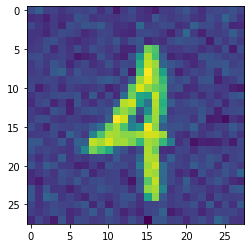

In [65]:
plt.figure(figsize=(4,4))
plt.imshow(MNIST_train_noisy[0].reshape(28,28));

Before we perform PCA, the data sets will have to be standardised. <br>
We will standardise the `MNIST_train_noisy` set using the formula: $$\frac{X - \mu}{\sigma}$$ where $\mu$ is the mean of X and $\sigma$ is the standard deviation of X. We define the function `standardise_train` to perform this procedure.

In [66]:
def standardise_train(X_train):
    """
    Arguments:
        X_train: training dataset
    
    Returns:
        Xbar: standardised training dataset
    """
    mu = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X_train-mu)/std_filled)
    return Xbar

We have to standardise the test dataset `MNIST_test_noisy` using the mean and standard deviation of the training dataset `MNIST_train_noisy`. We will define the function `standardise_test` to perform this procedure.

In [67]:
def standardise_test(X_test, X_train):
    """
    Arguments:
        X_train: training dataset
        X_test: test dataset
    
    Returns:
        Xbar: standardised test dataset
    """
    mu = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X_test-mu)/std_filled)
    return Xbar

Before standardising, we divide `MNIST_train_noisy` and `MNIST_test_noisy` by 255 to convert the pixels into floating numbers between 0 and 1. The standardised `MNIST_train_noisy` and `MNIST_test_noisy` will be assigned to `train_noisy_s` and `test_noisy_s` respectively.

In [68]:
train_noisy_s = standardise_train(MNIST_train_noisy / 255.)
test_noisy_s = standardise_test(MNIST_test_noisy / 255., MNIST_train_noisy / 255.)

The `pca_function` performs the following steps:
1. Compute the covariance matrix  $\mathbf C = \mathbf X^\top \mathbf X/(n-1)$
1. Find eigenvalues and corresponding eigenvectors for the covariance matrix, $\mathbf C = \mathbf V \mathbf L \mathbf V^\top,$
3.  Sort by the largest eigenvalues and the corresponding eigenvectors.
4.  Compute the projection onto the spaces spanned by the top $m$ eigenvectors.

In [69]:
def pca_function(X, m):
    """
    Arguments:
        X: training set
        m: number of principal components
    Returns:
        X_pca: projection onto the spaces spanned by the top m eigenvectors
        eigenvectors: top m eigenvectors of the covariance matrix C
        eigenvalues: top m eigenvalues of the covariance matrix C
    """
    # create covariance matrix C
    C = 1.0/(len(X)-1) * np.dot(X.T, X)

    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, m, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

We now plot the fraction of variance explained by PCA against m.

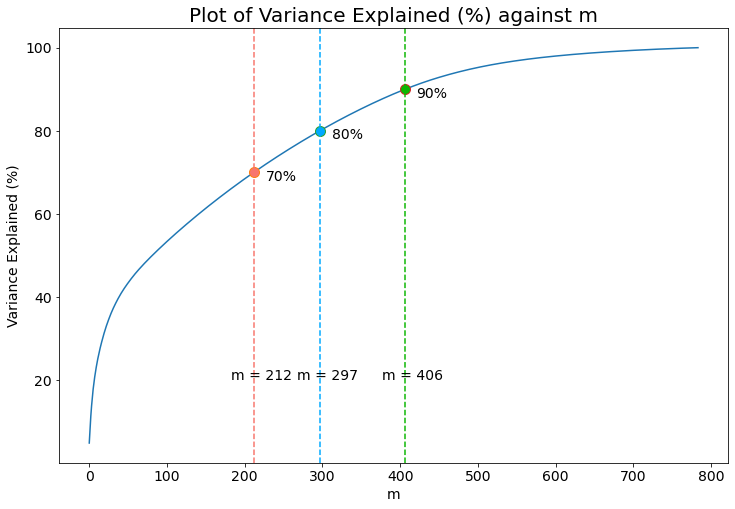

In [72]:
m = train_noisy_s.shape[1]
X_pca, eigenvectors, eigenvalues = pca_function(train_noisy_s, m)
total_var = sum(eigenvalues)
var_explained = np.cumsum(eigenvalues) / total_var * 100
percentage = [70, 80, 90]
index_list = []
var_list = []

for i in range(len(percentage)):
    index = np.argmin(np.abs(var_explained - percentage[i]))
    index_list.append(index)
    var_list.append(var_explained[index])

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(var_explained)
plt.plot(index_list[0], var_list[0], marker='o', markerfacecolor="#F8766D", markersize=10)
plt.plot(index_list[1], var_list[1], marker='o', markerfacecolor="#00A9FF", markersize=10)
plt.plot(index_list[2], var_list[2], marker='o', markerfacecolor="#0CB702", markersize=10)
for i, j in enumerate(percentage):
    plt.annotate("{}%".format(j), (index_list[i]+15, j-2), fontsize=14)
    plt.annotate("m = {}".format(index_list[i]), (index_list[i] - 30, 20), fontsize=14)
plt.axvline(x=index_list[0], color="#F8766D", linestyle='dashed')
plt.axvline(x=index_list[1], color="#00A9FF", linestyle='dashed')
plt.axvline(x=index_list[2], color="#0CB702", linestyle='dashed')
    
plt.xlabel('m',fontsize=14)
plt.ylabel('Variance Explained (%)',fontsize=14)
plt.title("Plot of Variance Explained (%) against m", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

In [73]:
# Table of m and fraction of variance explained by PCA
data_pca = {'': ["70%", index_list[0]], ' ': ["80%", index_list[1]], '  ':["90%", index_list[2]]}
df_pca = pd.DataFrame(data_pca, index=['Percentage', 'm'])
df_pca = df_pca.style.set_properties(**{'font-size': '14pt'})
df_pca = df_pca.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_pca

,,,
Percentage,70%,80%,90%
m,212,297,406


We visualise the first m=10 principal components from PCA.

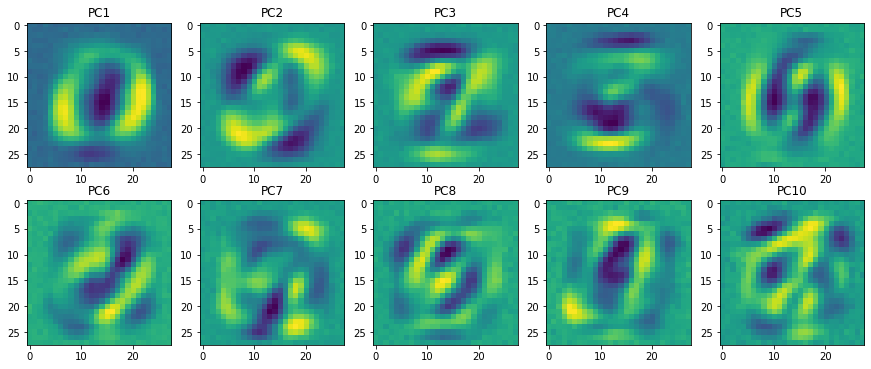

In [74]:
m = 10
X_pca, eigenvectors, eigenvalues = pca_function(train_noisy_s, m)

fig, axs = plt.subplots(2, 5,figsize=(15,6))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors[:,i].reshape([28,28]))
    ax.set_title("PC{}".format(i+1))
plt.show()

Before we perform NMF, the data sets will have to be normalised. <br>
We will normalise the `MNIST_train_noisy` set using the formula: $$\frac{X - \min(X)}{\max(X) - \min(X)}$$ We define the function `normalize_nmf_train` to perform this procedure.

In [75]:
# normalise min max to 0-1
def normalize_nmf_train(X):
    """
    Arguments:
        X: training dataset
    
    Returns:
        X_norm: normalised training dataset
    """
    X_norm = (X- np.min(X)) / (np.max(X) - np.min(X))
    return X_norm

We have to normalise the test dataset `MNIST_test_noisy` using the minimum and maximum of the training dataset `MNIST_train_noisy`. We will define the function `normalize_nmf_test` to perform this procedure.

In [76]:
def normalize_nmf_test(X_test, X_train):
    """
    Arguments:
        X_train: training dataset
        X_test: test dataset
    
    Returns:
        X_norm: normalised test dataset
    """
    X_norm = (X_test - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
    return X_norm

Before normalising, we divide `MNIST_train_noisy` and `MNIST_test_noisy` by 255 to convert the pixels into floating numbers between 0 and 1. The normalised `MNIST_train_noisy` and `MNIST_test_noisy` will be assigned to `train_noisy_n` and `test_noisy_n` respectively.

In [77]:
train_noisy_n = normalize_nmf_train(MNIST_train_noisy / 255.)
test_noisy_n = normalize_nmf_test(MNIST_test_noisy / 255., MNIST_train_noisy / 255.)

The `cost` function computes the loss using the formula:
$$\chi^2 = \frac{e^⊤ (X \odot d \odot d) e}{n}$$
where d is the difference $d = X - WH$, and e is a vector of all ones where $e^⊤ K e$ simply performs a sum over all elements in K, and $n$ is the total number of elements in $X$. The symbol $\odot$ is the element wise product (Hadamard product).

In [78]:
def cost(X, W, H):
    """
    Arguments:
        X: training set
        W: matrix of non-negative coefficients expressing the data x in the basis of vectors in H
        H: matrix of non-negative equivalent of the principal components
    Returns:
        chi2: loss
    """
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H)

    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1])
    
    return chi2

The `NMF` function factors the n-by-m feature matrix $\mathbf X$ into nonnegative factors $\mathbf W$ (n-by-k) and $\mathbf H$ (k-by-m). <br>
Here we will use Lee and Seung's multiplicative update rule. 

<center>
$
\mathbf{H}_{[i,j]}^{n+1}\leftarrow \mathbf{H}_{[i,j]}^{n} 
\frac{(( \mathbf{W}^n)^T \mathbf{X})_{[i,j]}}{((\mathbf{W}^n)^T \mathbf{W}^n \mathbf{H}^n)_{[i,j]}}
$
</center>

and

<center>
$
\mathbf{W}_{[i,j]}^{n+1}\leftarrow \mathbf{W}_{[i,j]}^{n} 
\frac{(\mathbf{X}(\mathbf{H}^{n+1})^T)_{[i,j]}}{(\mathbf{W}^n \mathbf{H}^{n+1} (\mathbf{H}^{n+1})^T)_{[i,j]}}
$
</center>

until $\mathbf{W}$ and $\mathbf{H}$ are stable.

In [79]:
def NMF(X, m, n_iters):
    """
    Arguments:
        X: training set
        m: number of NMF components
        n_iters: number of iterations
    Returns:
        H: matrix of non-negative equivalent of the principal components
        W: matrix of non-negative coefficients expressing teh data x in the basis of vectors in H
        cost_values: list of costs computed for each iteration
    """
    # m x P matrix interpreted as the basis set, where m is the number of components, P the number of descriptors of the data
    H = np.random.rand(m, X.shape[1])

    # N x m components matrix, usually interpreted as the coefficients, N is the number of data
    W = np.random.rand(X.shape[0], m)

    # set the number of iterations
    n_iters = 500
    pseudo_count = 0.001 # this is just a small value that we place at the denominator to avoid division by zero

    # empty list 
    cost_values = []

    # loop over the n iterations
    for i in range(n_iters):

        # compute the update on H
        H = H * ((W.T.dot(X))/(W.T.dot(W.dot(H))+pseudo_count))

        # compute the update on W
        W = W * ((X.dot(H.T))/(W.dot(H.dot(H.T))+pseudo_count))

        # compute the cost and append to list
        cost_values.append(cost(X,W,H))
    return H, W, cost_values

We perform dimensionality reduction implementing NMF with m=10 dimensions and plots the loss as a function of the number of iterations.

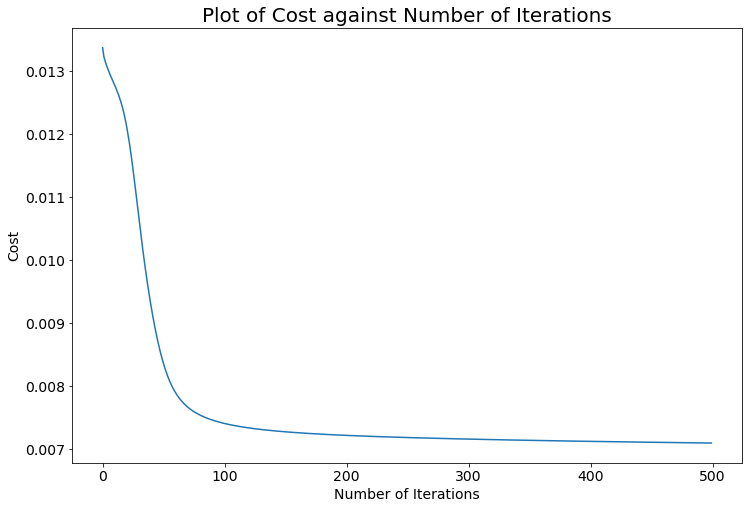

In [80]:
H, W, cost_values = NMF(train_noisy_n, 10, 500)

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(cost_values)
plt.xlabel('Number of Iterations',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.title("Plot of Cost against Number of Iterations", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

We can observe from the plot above that the cost has converged to 0.007 and that 500 iterations are sufficient for convergence.<br>
We now visualise the m=10 NMF components from PCA.

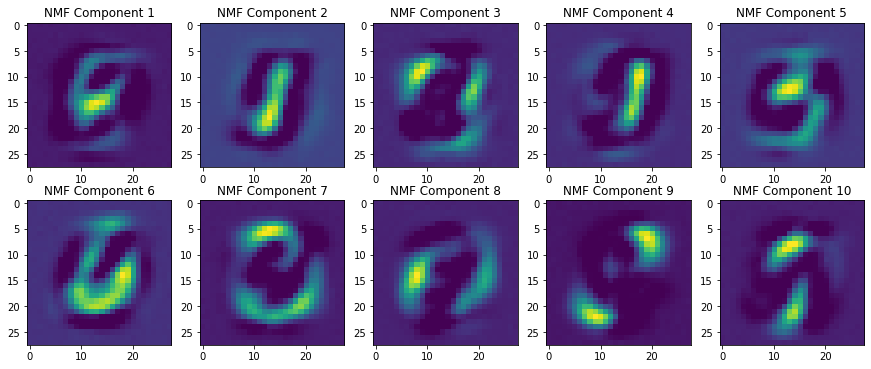

In [81]:
fig, axs = plt.subplots(2, 5, figsize=(15,6))

for i,ax in enumerate(axs.reshape(-1)): 
    ax.imshow(H[i,:].reshape([28,28]))
    ax.set_title("NMF Component {}".format(i+1))
plt.show()

Some of the PCA components resemble distorted versions of the whole digits. For example, PC1 resembles the distorted version of the digit 0 and PC4 resembles the distorted version of the digit 3. This is because PCA finds the top 10 principal components that capture the most variation in the data. PCA assumes that the data is normally distributed and linearly related, and can be applied to both positive and negative values. As the components are linear combinations of the original pixels, the cancellations between positive and negative numbers cause some of the principal components to lack intuitive meaning.<br>

On the other hand, the NMF components represent features of the digits. For example, NMF component 4 represents the straight edges in the digits 1, 4 or 7 and NMF component 7 represents the circles in the digits 0, 6, 8 or 9. This is because NMF factorises the data matrix into two non-negative matrices, such that the product of the matrices approximates the original matrix. NMF assumes that the data is non-negative and additive, and can only be applied to non-negative values. In contrast to PCA, no subtratcions can occur. For this reasons, NMF learns a parts-based representation of the digits.

We train PCA and NMF on *MNIST_train_noisy.txt* to find the set of principal components in PCA and non-negative components in NMF, using m=100 for both PCA and NMF.

In [82]:
m = 100
X_pca, eigenvectors, eigenvalues = pca_function(train_noisy_s, m)
H, W, cost_values = NMF(train_noisy_n, m, 500)

As in task **1.2.2**, we plot the loss for implementing NMF as a function of the number of iterations, showing that 500 iterations is sufficient for convergence.

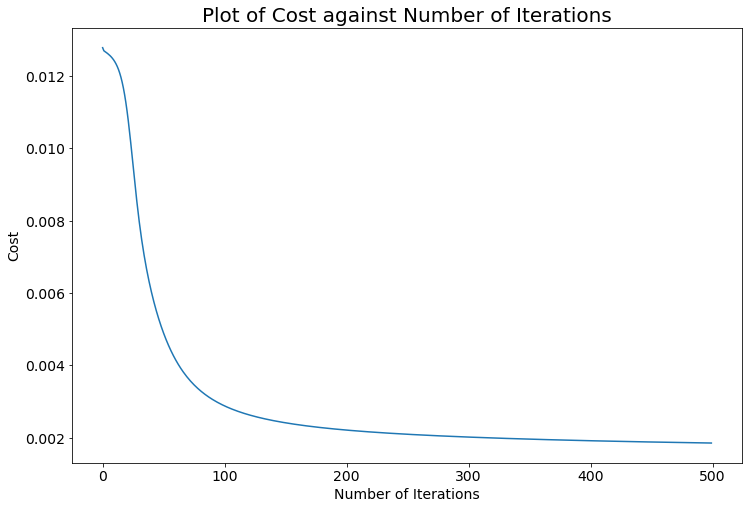

In [83]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(cost_values)
plt.xlabel('Number of Iterations',fontsize=14)
plt.ylabel('Cost',fontsize=14)
plt.title("Plot of Cost against Number of Iterations", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

We can observe from the plot above that the cost has converged to 0.002 and that 500 iterations are sufficient for convergence.

Using the trained principal components in PCA, we reconstruct the test set of noisy images using the formula:
$$X_{\text{reconstruct}} \approx XVV^{T}$$
where $VV^{T}$ is the projection matrix which projects the test set of noisy images onto the vector space spanned by the eigenvectors.<br>
Using the trained non-negative components in NMF, we reconstruct the test set of noisy images using the formula:
$$X_{\text{reconstruct}} \approx XH^{T}H$$
where $H^{T}H$ is the projection matrix which projects the test set of noisy images onto the vector space spanned by the non-negative equivalent of the principal components.

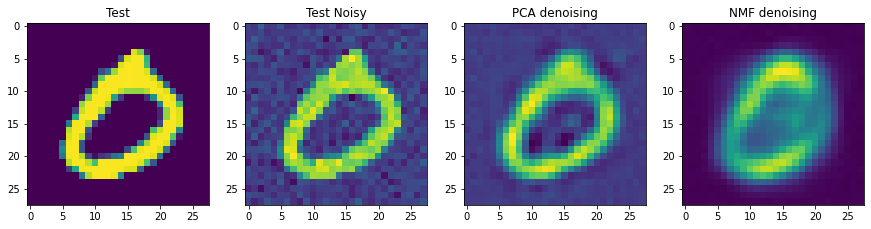

In [84]:
# PCA
projection_PCA = eigenvectors @ eigenvectors.T
PCA_denoise = test_noisy_s @ projection_PCA
PCA_denoise = PCA_denoise * np.std(MNIST_train_noisy / 255., axis=0) + np.mean(MNIST_train_noisy / 255., axis=0)
PCA_denoise = PCA_denoise * 255.

# NMF
projection_NMF = H.T @ H
NMF_denoise = test_noisy_n @ projection_NMF
NMF_denoise = NMF_denoise * (np.max(MNIST_train_noisy / 255.) - np.min(MNIST_train_noisy / 255.)) + np.min(MNIST_train_noisy / 255.)
NMF_denoise = NMF_denoise * 255.

fig, ax = plt.subplots(figsize=(15,6))

plt.subplot(1, 4, 1)
plt.imshow(MNIST_test[:, 1:][0].reshape(28,28))
plt.title("Test")

plt.subplot(1, 4, 2)
plt.imshow(MNIST_test_noisy[0].reshape(28,28))
plt.title("Test Noisy")

plt.subplot(1, 4, 3)
plt.imshow(PCA_denoise[0].reshape(28,28))
plt.title("PCA denoising")

plt.subplot(1, 4, 4)
plt.imshow(NMF_denoise[0].reshape(28,28))
plt.title("NMF denoising")

plt.show()

For the noisy test image reconstructed via PCA, we can observe that the edges of the digit are smoother and sharper, but the image still contains noise.

For the noisy test image reconstructed via NMF, we can observe that the edges of the digit are rougher and more blur, but there is no obvious noise visible in the reconstructed image.

Thus, we can conclude that for the MNIST data set, NMF does a better job at noise reduction than PCA, but PCA does a better job at reconstructing smoother denoised images than NMF for m=100 components.

The `mse` function computes the mean squared error between two sets of images:
$$\frac{1}{N}\sum^{N}_{i=1}{\frac{\sum_{P, Q}{(I_{1N}(p,q)-I_{2N}(p,q))^{2}}}{PQ}}$$
where $I_{1N}$ and $I_{2N}$ represents the Nth image in the set of images $I_{1}$ and $I_{2}$ respectively. P and Q represents the number of rows and columns of the images, which are both 28 in this case.

In [85]:
def mse(predict, actual):
    return np.square(predict - actual).mean(axis = 1).mean()

We compute the mean squared error between the reconsructed images using PCA and the test set of uncorrupted images and the test set of noise-corrupted images for different number of PCA components m in the interval 5-400 with a step size of 5.

In [86]:
m_list = np.arange(5, 405, 5)
mse_list_test = []
mse_list_test_noisy = []

for m in m_list:
    X_pca, eigenvectors, eigenvalues = pca_function(train_noisy_s, m)
    projection_PCA = eigenvectors @ eigenvectors.T
    PCA_denoise = test_noisy_s @ projection_PCA
    PCA_denoise = PCA_denoise * np.std(MNIST_train_noisy / 255., axis=0) + np.mean(MNIST_train_noisy / 255., axis=0)
    PCA_denoise = PCA_denoise * 255.
    mse_list_test.append(mse(PCA_denoise, MNIST_test[:, 1:]))
    mse_list_test_noisy.append(mse(PCA_denoise, MNIST_test_noisy))

We plot on the same figure these two MSEs as a function of the number of PCA components m.

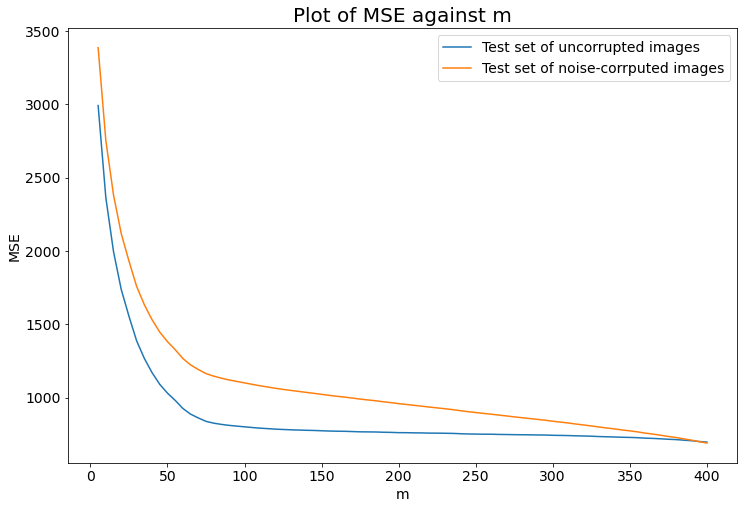

In [87]:
fig, ax = plt.subplots(figsize=(12,8))
plt.plot(m_list, mse_list_test, label="Test set of uncorrupted images")
plt.plot(m_list, mse_list_test_noisy, label="Test set of noise-corrputed images")
  
plt.xlabel('m',fontsize=14)
plt.ylabel('MSE',fontsize=14)
plt.title("Plot of MSE against m", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.legend(loc="best",fontsize=14)
plt.show()

We can observe that the MSE between the reconstructed images and the test set of uncorrupted images generally lie below the MSE between the reconstructed images and the test set of noise-corrupted images for m in the interval of 5-400. This implies that the reconstructed images using m in the interval 5-400 is more similar to the test set of uncorrupted images than the test set of noise-corrupted images. <br>

For m less than 75, we note that the MSE for both between the reconstructed images and the test set of uncorrupted and  between the reconstructed images and the test set of noise-corrupted images, decrease exponentially as m increases. This is because the reconstrcuted images recovers the features in the digits, resulting in the large drop in MSE.<br>

In addition, for m greater than 75, we can notice that the MSE between the reconstructed images and the test set of uncorrupted images hits a plateau and remains reasonably constant at a value of approximately 700. We can infer that the increase in clarity of the digits and the increase in noise recovered from the test set of noise-corrupted images cancel out as m increases, causing the MSE to remain constant. <br>

On the other hand, for m greater than 75, we can see that the MSE between the reconstructed images and the test set of noise-corrupted images gradually decreases as m increases and eventually goes below the MSE between the reconstructed images and the test set of uncorrupted images at m=400. This is because as m increases, PCA recovers the test set of noise-corrupted images, thus the reconstructed images become more and more similar to the test set of noise-corrupted images, resulting in the continuous decrease in MSE.

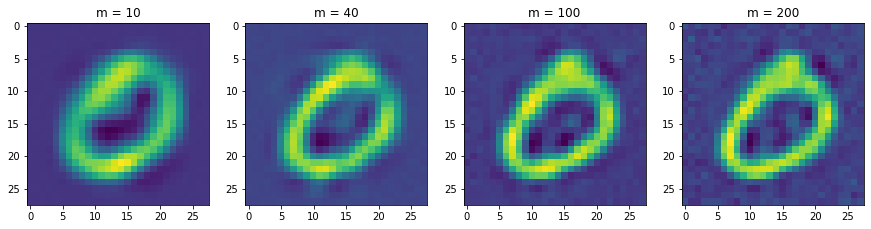

In [88]:
fig, ax = plt.subplots(figsize=(15,6))

for i, m in enumerate([10, 40, 100, 200]):
    X_pca, eigenvectors, eigenvalues = pca_function(train_noisy_s, m)
    projection_PCA = eigenvectors @ eigenvectors.T
    PCA_denoise = test_noisy_s @ projection_PCA
    PCA_denoise = PCA_denoise * np.std(MNIST_train_noisy / 255., axis=0) + np.mean(MNIST_train_noisy / 255., axis=0)
    PCA_denoise = PCA_denoise * 255.
    plt.subplot(1, 4, i+1)
    plt.imshow(PCA_denoise[0].reshape(28,28))
    plt.title("m = {}".format(m))
    
plt.show()

For m=10, we observe that the image reconstructed recovers a blur image of the digit with no noise. <br>

As m increases to 40, the edges of the digit become sharper and clearer, while a small amount of noise becomes visible. This matches the exponential decrease in MSE for both between the reconstructed images and the test set of uncorrupted images and between the reconstructed images and the test set of noise-corrupted images. <br>

As m increases to 100, the edges of the digit become much sharper and clearer, but the amount of noise visible increases. This corresponds to the plateau in the MSE between the reconstructed images and the test set of uncorrupted images and the gradual decrease in MSE between the reconstructed images and the test set of noise-corrupted images.<br>

As m increases to 200, there is small increase in clarity of the digit compared m=100, but much more noise is recovered from the test set of noise-corrupted images.

## Gaussian Mixture Models

We start with the definition of a Gaussian Mixture Model (GMM):
$$
P(\boldsymbol{X}=\boldsymbol{x}) = \sum_{k=1}^K \pi_k p_k(\boldsymbol{x}|\boldsymbol{\theta})\, .
$$
Here $K$ is the number of clusters described as mixture components, each of which are multivariate normal distributions:
$$
p_k(\boldsymbol{x}|\boldsymbol{\theta}) = {\displaystyle (2\pi )^{-k/2}\det({\boldsymbol {\Sigma }_k})^{-1/2}\,\exp \left(-{\frac {1}{2}}(\mathbf {x} -{\boldsymbol {\mu }_k})^{\!{\mathsf {T}}}{\boldsymbol {\Sigma }_k}^{-1}(\mathbf {x} -{\boldsymbol {\mu }_k})\right),}
$$
where $\boldsymbol{\theta} = \{\pi_k,\mu_k, \Sigma_k \}_{k=1,2,...,K}$ is the vectors of parameters consiting of the mixture weight $\pi_k$, mixture component mean $\boldsymbol{\mu}_k$ and mixture component covariance matrix $\boldsymbol{\mu}_k$.

In [92]:
class GMModel:
    """Struct to define Gaussian Mixture Model"""
    """:param dim: number of mixture components"""
    """:param weights: mixture weights"""
    """:param mu: mixture component means for each cluster"""
    """:param sigma: mixture component covariance matrix for each cluster"""
    
    def __init__(self, X, dim):
        """Initialises parameters through random split of the data"""
        
        self.dim = dim

        # initial weights given to each cluster are stored in phi or P(Ci=j)
        self.phi = np.full(shape=self.dim, fill_value=1/self.dim) 

        # initial weights given to each data point wrt to each cluster or P(Xi/Ci=j)
        self.weights = np.full(shape=X.shape, fill_value=1/self.dim)
        
        n,m = X.shape 
        # dataset is divided randomly into k parts of unequal sizes
        random_row = np.random.randint(low=0, high=n, size=self.dim)

        # initial value of mean of k Gaussians
        self.mu = [X[row_index,:] for row_index in random_row]  

        # initial value of covariance matrix of k Gaussians
        self.sigma = [np.cov(X.T) for _ in range(self.dim)] 

We can perform 'soft' clustering of the data using the cluster probabilities of the data:
$$r_{ik}(\boldsymbol{\theta})=P(Z=k|\boldsymbol{X}=\boldsymbol{x}_i,\boldsymbol{\theta}) = \frac{\pi_k p_k(\boldsymbol{x}_i|\boldsymbol{\theta})}{\sum_{k'=1}^K \pi_{k'} p_{k'}(\boldsymbol{x}_i|\boldsymbol{\theta})}$$
The `cluster_probablities` function predicts the probability of data point $i$ to belong to cluster $k$.

In [93]:
def cluster_probabilities(gmm, X):
    """Predicts probability of each data point with respect to each cluster"""
    
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i])
        likelihood[:,i] = distribution.pdf(X) 

        numerator = likelihood * gmm.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / (denominator + 1e-50)
    return weights

The `predict` function presents the results as hard clusters on the output through the argmax of the cluster distribution.

In [94]:
def predict(gmm, X):
    """Performs hard clustering"""
    weights = cluster_probabilities(gmm,X)
    return np.argmax(weights, axis=1) 

We employ the EM algorithm to fit the data. The algorithm iteratively updates parameters of the Gausian Mixture. The algorithm is guarantees to improve (or at least not worsen) the marginal likelihood of the data. The algorithm updates the mixture weights:
$$
	\pi_k^{(n+1)} = \frac{1}{N}\sum_{i=1}^N r_{ik}(\boldsymbol{\theta}^{(n)}),
$$
and computes the cluster means using a weighted mean:
$$	\boldsymbol{\mu}_k^{(n+1)} =\sum_{i=1}^N w_{ik}(\boldsymbol{\theta}^{(n)}) \boldsymbol{x}_i$$
and similarly for the covariances according to
$$\boldsymbol{\Sigma}_k^{(n+1)}= \sum_{i=1}^N w_{ik}(\boldsymbol{\theta}^{(n)}) (\boldsymbol{x}_i-\boldsymbol{\mu}_k) (\boldsymbol{x}_i-\boldsymbol{\mu}_k)^T.$$
The weights are obtained from the cluster probabilities via
$$w_{ik}(\boldsymbol{\theta}^{(n)})=\frac{r_{ik}(\boldsymbol{\theta}^{(n)})}{\sum_{i'} r_{i'k}(\boldsymbol{\theta}^{(n)})}$$
The `fitStep` function implements one step in this iteration.

In [95]:
def fitStep(gmm,X):
    """Performs an EM step by updating all parameters"""
    
    # E-Step: update weights and phi holding mu and sigma constant
    weights = cluster_probabilities(gmm,X)
    gmm.phi = weights.mean(axis=0)
        
    # M-Step: update mu and sigma holding pi and weights constant
    for i in range(gmm.dim):
        weight = weights[:, [i]]
        total_weight = weight.sum()

        gmm.mu[i] = (X * weight).sum(axis=0) / total_weight 
        gmm.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

The `log_likelihood_gmm` computes the log-likelihood of the GMM constructed via:
$$\sum_{i}{\log\sum_{k=1}^K \pi_k p_k(\boldsymbol{x}|\boldsymbol{\theta})}$$

In [96]:
def log_likelihood_gmm(gmm, X):
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros((n, gmm.dim)) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i])
        likelihood[:,i] = gmm.phi[i] * distribution.pdf(X)
    return np.sum(np.log(np.sum(likelihood, axis=1)))

As the EM algorithm only guarantees convergence to a local minimum, we start the algorithm multiple times from different initial guesses to get the best GMM model that is closest to the global optimum. We evaluate each GMM model using the log-likelihood. The `train_gmm` function implements the preocedure stated above.

In [97]:
def train_gmm(X, m, initiate, max_iter, tolerance):
    """
    Arguments:
        X: input data
        m: number of hidden components
        initiate: number of initialisations
        max_iter: maximum number of iterations
        tolerance: check convergence of log-likelihood of gmm
    Returns:
        best_gmm: gmm model that is closest to the global optimum
    """
    best_gmm = None
    best_likelihood = float('-inf')
    
    for i in range(initiate):
        gmm = GMModel(X, m)
        likelihood_old = log_likelihood_gmm(gmm, X)
        for j in range(max_iter):
            fitStep(gmm, X)
            likelihood_new = log_likelihood_gmm(gmm, X)
            if np.abs(likelihood_new - likelihood_old) < tolerance:
                break
            else:
                likelihood_old = likelihood_new
        if likelihood_old > best_likelihood:
            best_gmm = gmm
            best_likelihood = likelihood_old
    return best_gmm

We use the first five principal components of the PCA on the first N=1000 images of the dataset *MNIST_train.csv* to perform clustering using a GMM with 10 hidden components.

In [125]:
train_subset = standardise_train(x_train)[0:1000,:]
X_pca, eigenvectors, eigenvalues = pca_function(train_subset, 5)
best_gmm_10 = train_gmm(X_pca, 10, 10, 1000, 1e-8)

The `plot_gmm` function visualises the space spanned by the top two principal components, colouring each point according to thier cluster.

In [184]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = predict(gmm,X)
    if label:
        plot = ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap=plt.cm.get_cmap('Paired', 10), zorder=2, vmin=-0.5, vmax=9.5)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    plt.colorbar(plot, label="Cluster Index", ticks=range(10))

    return ax

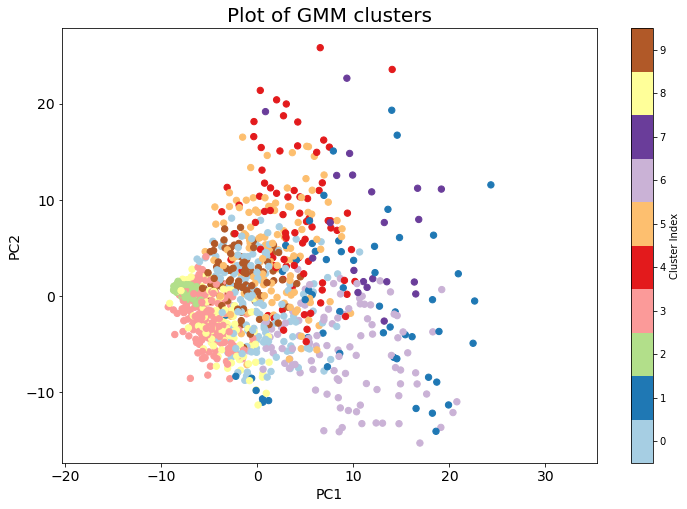

In [185]:
fig, ax = plt.subplots(figsize=(12,8))
plot_gmm(best_gmm_10, X_pca)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
plt.title("Plot of GMM clusters", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

The `plot_truth` function uses the class labels to visualise the space spanned by the first two principal components and colours each point according to their class label.

In [188]:
def plot_truth(X, y, label=True, ax=None):
    ax = ax or plt.gca()
    labels = y
    if label:
        plot = ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap=plt.cm.get_cmap('Paired', 10), zorder=2, vmin=-0.5, vmax=9.5)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    plt.colorbar(plot, label="Class Label", ticks=range(10))

    return ax

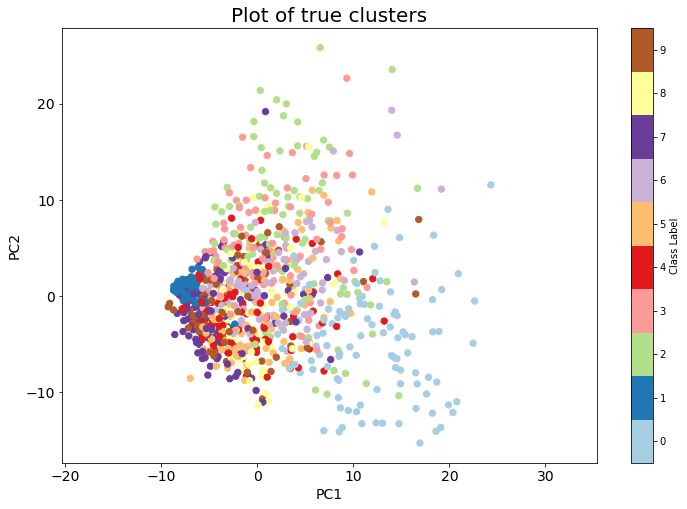

In [189]:
fig, ax = plt.subplots(figsize=(12,8))
true_labels = y_train[0:1000]
plot_truth(X_pca, true_labels, label=True)
plt.xlabel('PC1',fontsize=14)
plt.ylabel('PC2',fontsize=14)
plt.title("Plot of true clusters", fontsize=20)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

The `log_likelihood_data` function computes the log-likelihood of each mixture component for a single image via:
$$\log p_k(\boldsymbol{x}|\boldsymbol{\theta})$$

In [190]:
def log_likelihood_data(gmm, X):
    # n has the number of rows while m has the number of columns of dataset X
    n,m = X.shape 
    # Creates a n*k matrix denoting likelihood belonging to each cluster 
    likelihood = np.zeros( (n, gmm.dim) ) 
    for i in range(gmm.dim):
        # likelihood of data belonging to i-th cluster 
        distribution = multivariate_normal(mean=gmm.mu[i],cov=gmm.sigma[i])
        likelihood[:,i] = distribution.pdf(X)
    return np.log(likelihood + 1e-100)

We use the log-likelihood of each mixture component evaluated at the images in each class to measure the fit quality and map the class labels to the best-fitting cluster index.

In [191]:
log_likelihood_10 = log_likelihood_data(best_gmm_10, X_pca)

class_likelihood_10 = np.zeros((10, best_gmm_10.dim))
for i in range(10):
    index = np.where(true_labels == i)[0]
    class_likelihood_10[i, :] = np.sum(log_likelihood_10[index, :], axis=0)

map_list_10 = np.argmax(class_likelihood_10, axis=1)

In [192]:
# Table of map_list_10
data_map_10 = {'': [0, map_list_10[0]], ' ': [1, map_list_10[1]], '  ':[2, map_list_10[2]], '   ':[3, map_list_10[3]], '    ':[4, map_list_10[4]], '     ':[5, map_list_10[5]], '      ':[6, map_list_10[6]], '       ':[7, map_list_10[7]], '        ':[8, map_list_10[8]], '         ':[9, map_list_10[9]]}
df_map_10 = pd.DataFrame(data_map_10, index=['Class Label', 'Cluster Index'])
df_map_10 = df_map_10.style.set_properties(**{'font-size': '14pt'})
df_map_10 = df_map_10.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_map_10

,,,,,,,,,,
Class Label,0,1,2,3,4,5,6,7,8,9
Cluster Index,6,2,4,5,0,5,4,0,5,0


We use the label-cluster index map to compute the cluster probabilities for each digit. For each class, we visualise the space spanned by the top two principal components by colouring each point according to the cluster probability of the best-fitting cluster.

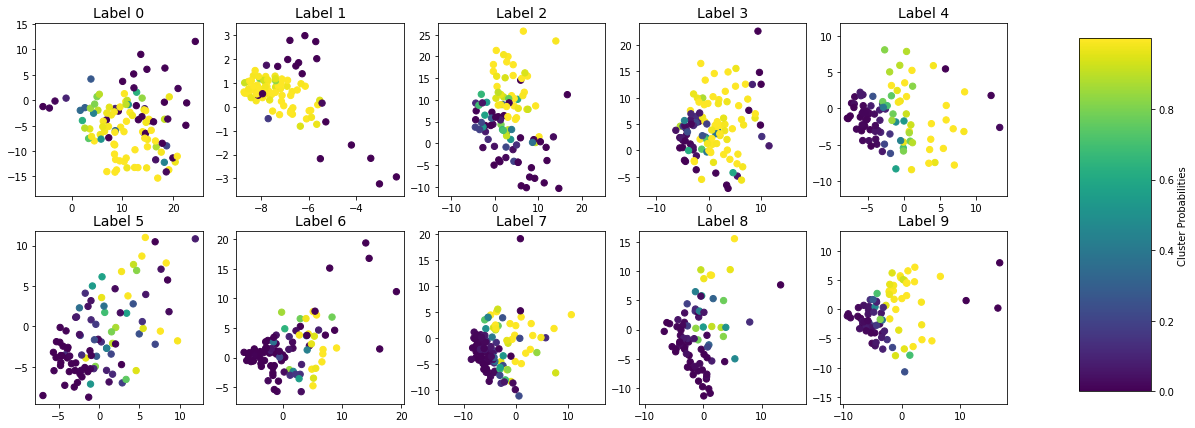

In [194]:
fig, ax = plt.subplots(figsize=(20, 7))

cluster_prob_10 = cluster_probabilities(best_gmm_10, X_pca)

for i, m in enumerate(map_list_10):
    index = np.where(true_labels == i)[0]
    cluster_prob_class_i = cluster_prob_10[index, m]
    plt.subplot(2, 5, i+1)
    plot = plt.scatter(X_pca[:, 0][index], X_pca[:, 1][index], c=cluster_prob_class_i, s=40, cmap='viridis', zorder=2)
    plt.axis('equal')
    plt.title("Label {}".format(i), fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plot, cax=cbar_ax, label="Cluster Probabilities")
plt.show()

According to the visualisation above, labels 0, 1 and 3 have a relatively high proportion of data points with cluster probabilities approximately one. This implies that most of the data points for these labels lie within the best-fitting cluster, which suggests that the GMM model with 10 hidden components is able to identify the clusters for these labels well. <br>

On the other hand, labels 5 and 8 have a relatively high proportion of data points with cluster probabilities approximately zero. This implies that most of the data points for these labels do not lie within the best-fitting cluster, which suggests that the GMM model with 10 hidden components is unable to identify the clusters for these labels well. <br>

The rest of the labels show a range of cluster probabilities reasonably distributed evenly. <br>

In addition, we can observe that some of the class labels have the same best-fitting cluster. Labels 2 and 6 have the same best-fitting cluster, labels 3, 5 and 8 have the same best-fitting cluster while labels 4, 7 and 9 have the same best-fitting cluster. We notice that the labels with the same best-fitting cluster have highly obvious similarities. Whereas labels 0 and 1 have distinct best-fitting clusters from the rest of the labels, which explains the high proportion of data points with cluster probabilities approximately one.

In [195]:
# m = 8
best_gmm_8 = train_gmm(X_pca, 8, 10, 1000, 1e-8)

log_likelihood_8 = log_likelihood_data(best_gmm_8, X_pca)

class_likelihood_8 = np.zeros((10, best_gmm_8.dim))
for i in range(10):
    index = np.where(true_labels == i)[0]
    class_likelihood_8[i, :] = np.sum(log_likelihood_8[index, :], axis=0)

map_list_8 = np.argmax(class_likelihood_8, axis=1)

In [196]:
# Table of map_list_8
data_map_8 = {'': [0, map_list_8[0]], ' ': [1, map_list_8[1]], '  ':[2, map_list_8[2]], '   ':[3, map_list_8[3]], '    ':[4, map_list_10[4]], '     ':[5, map_list_8[5]], '      ':[6, map_list_8[6]], '       ':[7, map_list_8[7]], '        ':[8, map_list_8[8]], '         ':[9, map_list_8[9]]}
df_map_8 = pd.DataFrame(data_map_8, index=['Class Label', 'Cluster Index'])
df_map_8 = df_map_8.style.set_properties(**{'font-size': '14pt'})
df_map_8 = df_map_8.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_map_8

,,,,,,,,,,
Class Label,0,1,2,3,4,5,6,7,8,9
Cluster Index,0,5,3,6,0,6,6,3,0,4


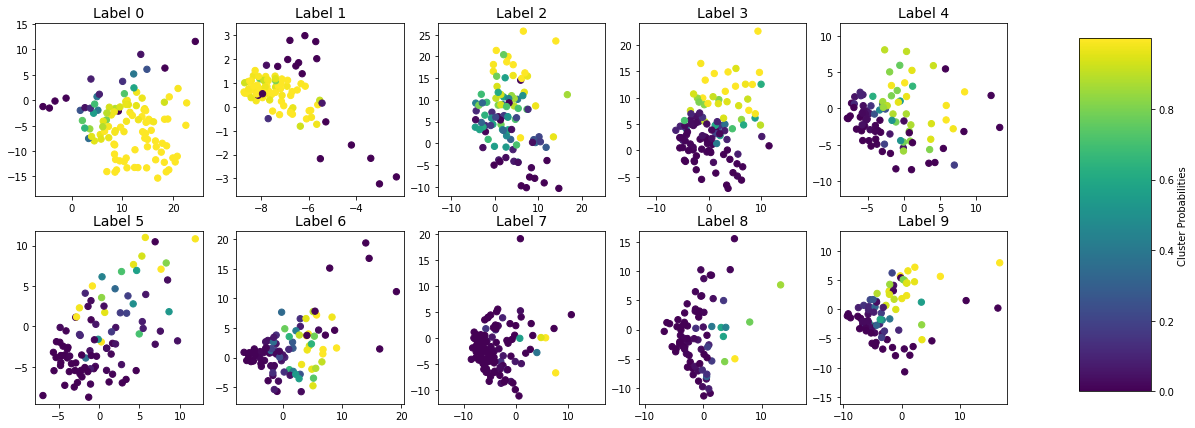

In [197]:
fig, ax = plt.subplots(figsize=(20, 7))

cluster_prob_8 = cluster_probabilities(best_gmm_8, X_pca)

for i, m in enumerate(map_list_8):
    index = np.where(true_labels == i)[0]
    cluster_prob_class_i = cluster_prob_8[index, m]
    plt.subplot(2, 5, i+1)
    plot = plt.scatter(X_pca[:, 0][index], X_pca[:, 1][index], c=cluster_prob_class_i, s=40, cmap='viridis', zorder=2)
    plt.axis('equal')
    plt.title("Label {}".format(i), fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plot, cax=cbar_ax, label="Cluster Probabilities")
plt.show()

For the GMM model with 8 hidden components, we observe that for label 0, the proportion of data points with cluster probabilities approximately one increases, implying that the GMM model with 8 hidden components does a better job in identifying the cluster for label 0 than the GMM model with 10 hidden components. <br>

The cluster probability distribution for label 1 is relatively the same for both the GMM model with 8 hidden components and 10 hidden components, which implies that the ability for both GMM models to identify the cluster for label 1 is fairly similar. <br>

On the other hand, in comparison to the GMM model with 10 hidden components, there are more labels with high proportions of data points with cluster probabilities approximately zero. Labels 3, 5, 6, 7 and 8 have a higher proportion of data points with cluster probabilities approximately zero. This suggests that the GMM model with 8 hidden components does a worse job in identifying the cluster for these labels than the GMM model with 10 hidden components. <br>

The rest of the labels show a range of cluster probabilities reasonably distributed evenly. <br>

Again, we can observe that some of the class labels have the same best-fitting cluster. Labels 0, 4 and 8 have the same best-fitting cluster, labels 2 and 7 have the same best-fitting cluster while labels 3, 5 and 6 have the same best-fitting cluster. We notice that the labels with the same best-fitting cluster still have similarities, but might be less obvious compared to the ones in the GMM model with 10 hidden components.

In [198]:
# m = 5
best_gmm_5 = train_gmm(X_pca, 5, 10, 1000, 1e-8)

log_likelihood_5 = log_likelihood_data(best_gmm_5, X_pca)

class_likelihood_5 = np.zeros((10, best_gmm_5.dim))
for i in range(10):
    index = np.where(true_labels == i)[0]
    class_likelihood_5[i, :] = np.sum(log_likelihood_5[index, :], axis=0)

map_list_5 = np.argmax(class_likelihood_5, axis=1)

In [199]:
# Table of map_list_5
data_map_5 = {'': [0, map_list_5[0]], ' ': [1, map_list_5[1]], '  ':[2, map_list_5[2]], '   ':[3, map_list_5[3]], '    ':[4, map_list_5[4]], '     ':[5, map_list_5[5]], '      ':[6, map_list_5[6]], '       ':[7, map_list_5[7]], '        ':[8, map_list_5[8]], '         ':[9, map_list_5[9]]}
df_map_5 = pd.DataFrame(data_map_5, index=['Class Label', 'Cluster Index'])
df_map_5 = df_map_5.style.set_properties(**{'font-size': '14pt'})
df_map_5 = df_map_5.set_table_styles([{'selector': 'th', 'props': [('font-size', '14pt')]}])
df_map_5

,,,,,,,,,,
Class Label,0,1,2,3,4,5,6,7,8,9
Cluster Index,0,3,4,0,1,0,4,1,0,4


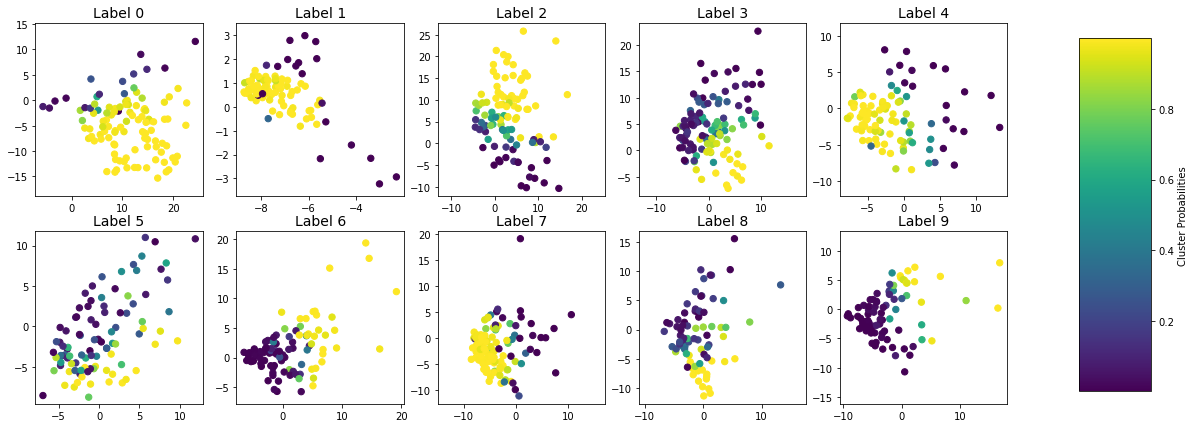

In [200]:
fig, ax = plt.subplots(figsize=(20, 7))

cluster_prob_5 = cluster_probabilities(best_gmm_5, X_pca)

for i, m in enumerate(map_list_5):
    index = np.where(true_labels == i)[0]
    cluster_prob_class_i = cluster_prob_5[index, m]
    plt.subplot(2, 5, i+1)
    plot = plt.scatter(X_pca[:, 0][index], X_pca[:, 1][index], c=cluster_prob_class_i, s=40, cmap='viridis', zorder=2)
    plt.axis('equal')
    plt.title("Label {}".format(i), fontsize=14)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plot, cax=cbar_ax, label="Cluster Probabilities")
plt.show()

The cluster probability distribution for labels 0 and 1 are relatively the same for both the GMM model with 5 hidden components and 8 hidden components, which implies that the ability for both GMM models to identify the cluster for labels 0 and 1 is fairly similar. <br>

In contrast to the GMM model with 10 hidden components, the rest of the labels show a range of cluster probabilities reasonably distributed evenly. <br>

Again, we can observe that some of the class labels have the same best-fitting cluster. Labels 0, 3, 5 and 8 have the same best-fitting cluster, labels 2, 6 and 9 have the same best-fitting cluster while labels 4 and 7 have the same best-fitting cluster. We can notice that the groups of same best-fitting cluster for the GMM model with 5 hidden components highly conincide with the groups of same best-fitting cluster for the GMM model with 10 hidden components. <br>

In addition, we note that for the GMM model with 5, 8 and 10 hidden components, the label 1 always has a distinct cluster index from all the other labels. This suggests that the label 1 has highly distinctive features.